# Models

In [1]:
import numpy as np
import sympy as sp

# parameters
class PAR:
    l1 = 1.0 # length of pendulum 1
    l2 = 1.0 # length of pendulum 2
    g = 9.81 # gravity
    μ1 = 0.1 # damping coefficient
    μ2 = 0.1 # damping coefficient
    m1 = .1 # mass of pendulum 1
    m2 = .1 # mass of pendulum 2
    mc = .1 # mass of cart

In [2]:
# utils
def sp2np(f:sp.Function):
    '''sketchy way to convert sympy expression to numpy'''
    f = f.simplify()
    f = str(f)
    subs = [('u(t)', 'u')]
    for i in range(1, 7):
        subs.append((f'Derivative(s{i}(t), (t, 3))', f'ddds{i}'))
        subs.append((f'Derivative(s{i}(t), (t, 2))', f'dds{i}'))
        subs.append((f'Derivative(s{i}(t), (t, 1))', f'ds{i}'))
        subs.append((f'Derivative(s{i}(t), t)', f'ds{i}')) 
        subs.append((f's{i}(t)', f's{i}'))
    for s in subs: f = f.replace(*s)
    return f

# Taylor approximation at s0 of the function 'f'
def taylor(f:sp.Function,s:sp.Symbol,s0:float,n:int):
    def factorial(n):
        if n <= 0: return 1
        else: return n*factorial(n-1)
    i, p = 0, 0
    while i <= n:
        p = p + (f.diff(s,i).subs(s,s0))/(factorial(i))*(s-s0)**i
        i += 1
    return p

def linear_system(f:sp.Function, states:list, inputs:list, s_eq:list):
    raise NotImplementedError
    # linearize the system around the equilibrium point s0
    # NOTE: states and their derivatives must be in the order with derivatives first
    n, m = len(states), len(inputs)
    A = sp.zeros(n,n)
    B = sp.zeros(n,m)
    for i in range(n):
        for j in range(n):
            aij = taylor(f, states[i], s_eq[i], 1)
            for k in range(n):
                if k == i: aij = aij.subs(states[k], 1)
                else: aij = aij.subs(states[k], 0) 
        for j in range(m):
            B[i,j] = s_eq[i].diff(inputs[j])
    


In [3]:
#save the file with the model equations
MODELS_EQ_PATH = 'models_eq.py'
with open(MODELS_EQ_PATH, 'w') as file:
    file.write('# This file has been automatically generated by models.ipynb\n')
    file.write(f'from numpy import sin, cos\n\n')
    #save parameters
    file.write(f'# parameters\n')
    file.write(f'class PAR:\n')
    for k, v in vars(PAR).items():
        if not k.startswith('__'): file.write(f'    {k} = {v}\n')

In [4]:
# single pendulum
t = sp.symbols('t', real=True)
u = sp.symbols('u', cls=sp.Function, real=True)(t)

# single pendulum
l1, m1, g, μ1 = sp.symbols('l1 m1 g μ1', positive=True, real=True) 
s1 = sp.symbols('s1', cls=sp.Function, real=True)(t) 
ds1 = sp.diff(s1, t)
dds1 = sp.diff(ds1, t)

V = m1 * g * l1 * sp.cos(s1) # potential energy
T = 0.5 * m1 * (l1 * ds1)**2 # kinetic energy
L = T - V # lagrangian
print('\nLagrangian:')
print(sp2np(L))

L1 = L.diff(s1) - (L.diff(ds1)).diff(t) - μ1 * ds1 + u
print('\nEuler-Lagrange equation:')
print(sp2np(L1))

# solve
sol = sp.solve(L1, dds1, simplify=False)
dds1 = sol[0]
print('\nSolved:')
print(f'dds1 == {sp2np(dds1)}')

# # linearize around s1=0
# ldds1_s1 = taylor(dds1, s1, 0, 1).subs(u, 0).subs(ds1, 0).subs(s1, 1)
# ldds1_ds1 = taylor(dds1, ds1, 0, 1).subs(u, 0).subs(ds1, 1).subs(s1, 0)
# # ldds1_ds1 = taylor(dds1, ds1, 0, 1).subs(u, 0).subs(s1, 0).subs(ds1, 1) # wrong
# print('\nLinearized around s1=0:')
# print(f'A11 == {sp2np(ldds1_s1)}')
# print(f'A12 == {sp2np(ldds1_ds1)}')

# sobstitute parameters
dds1 = dds1.subs([(l1, PAR.l1), (m1, PAR.m1), (g, PAR.g), (μ1, PAR.μ1)])
print('\nSubstituted parameters:')
print(sp2np(dds1))

# save the model to file
with open(MODELS_EQ_PATH, 'a') as file:
    file.write(f'\n# single pendulum\n')
    file.write(f'class SinglePendulum():\n')
    file.write(f'    @staticmethod\n')
    file.write(f'    def f(s1, ds1, u):\n')
    file.write(f'        return {sp2np(dds1)}\n')    


Lagrangian:
l1*m1*(-g*cos(s1) + 0.5*l1*ds1**2)

Euler-Lagrange equation:
g*l1*m1*sin(s1) - 1.0*l1**2*m1*dds1 - μ1*ds1 + u

Solved:
dds1 == (g*l1*m1*sin(s1) - μ1*ds1 + u)/(l1**2*m1)

Substituted parameters:
10.0*u + 9.81*sin(s1) - 1.0*ds1


In [5]:
# double pendulum
l1, l2, m1, m2, g, μ1, μ2 = sp.symbols('l1 l2 m1 m2 g μ1 μ2', positive=True, real=True)
s1 = sp.symbols('s1', cls=sp.Function, real=True)(t)
s2 = sp.symbols('s2', cls=sp.Function, real=True)(t)
ds1, ds2 = sp.diff(s1, t), sp.diff(s2, t)
dds1, dds2 = sp.diff(ds1, t), sp.diff(ds2, t)
x1, y1 = l1 * sp.sin(s1), l1 * sp.cos(s1)
x2, y2 = x1 + l2 * sp.sin(s2), y1 + l2 * sp.cos(s2)
dx1, dy1 = sp.diff(x1, t), sp.diff(y1, t)
dx2, dy2 = sp.diff(x2, t), sp.diff(y2, t)

V = m1 * g * y1 + m2 * g * y2 # potential energy
T = 0.5 * m1 * (dx1**2 + dy1**2) + 0.5 * m2 * (dx2**2 + dy2**2) # kinetic energy
L = T - V # lagrangian
print('\nLagrangian:')
print(sp2np(L))
L1 = L.diff(s1) - (L.diff(ds1)).diff(t) - μ1 * ds1 + u
L2 = L.diff(s2) - (L.diff(ds2)).diff(t) - μ2 * ds2

print('\nEuler-Lagrange equation:')
print(sp2np(L1))
print(sp2np(L2))
#  equations are almost too long to solve without substituting the actual parameters -> substitute first
L1 = L1.subs({l1:PAR.l1, l2:PAR.l2, m1:PAR.m1, m2:PAR.m2, g:PAR.g, μ1:PAR.μ1, μ2:PAR.μ2})
L2 = L2.subs({l1:PAR.l1, l2:PAR.l2, m1:PAR.m1, m2:PAR.m2, g:PAR.g, μ1:PAR.μ1, μ2:PAR.μ2})

# solve
sol = sp.solve([L1, L2], [dds1, dds2], simplify=False)
dds1, dds2 = sol[dds1], sol[dds2]
print('\nSolved:')
print(f'dds1 == {dds1}')
print(f'dds2 == {dds2}')
print(f'dds1 == {sp2np(dds1)}')
print(f'dds2 == {sp2np(dds2)}')

# # linearize around s1=s2=0
# ldds1_s1 = taylor(dds1, s1, 0, 1).subs(u, 0).subs(ds1, 0).subs(s1, 1).subs(ds2, 0).subs(s2, 0)
# ldds1_ds1 = taylor(dds1, ds1, 0, 1).subs(u, 0).subs(ds1, 1).subs(s1, 0).subs(ds2, 0).subs(s2, 0)
# ldds2_s2 = taylor(dds2, s2, 0, 1).subs(u, 0).subs(ds2, 0).subs(s2, 1).subs(ds1, 0).subs(s1, 0)
# ldds2_ds2 = taylor(dds2, ds2, 0, 1).subs(u, 0).subs(ds2, 1).subs(s2, 0).subs(ds1, 0).subs(s1, 0)
# print('\nLinearized around s1=s2=0:')
# print(f'A11 == {sp2np(ldds1_s1)}')
# print(f'A12 == {sp2np(ldds1_ds1)}')
# print(f'A13 == {sp2np(ldds2_s2)}')
# print(f'A14 == {sp2np(ldds2_ds2)}')

# sobstitute parameters
dds1 = dds1.subs([(l1, PAR.l1), (l2, PAR.l2), (m1, PAR.m1), (m2, PAR.m2), (g, PAR.g), (μ1, PAR.μ1), (μ2, PAR.μ2)])
dds2 = dds2.subs([(l1, PAR.l1), (l2, PAR.l2), (m1, PAR.m1), (m2, PAR.m2), (g, PAR.g), (μ1, PAR.μ1), (μ2, PAR.μ2)])
print('\nSubstituted parameters:')
print(sp2np(dds1))
print(sp2np(dds2))

# save the model to file
with open(MODELS_EQ_PATH, 'a') as file:
    file.write(f'\n# double pendulum\n')
    file.write(f'class DoublePendulum():\n')
    file.write(f'    @staticmethod\n')
    file.write(f'    def f(s1, s2, ds1, ds2, u):\n')
    file.write(f'        return {sp2np(dds1)}, {sp2np(dds2)}\n')


Lagrangian:
-g*l1*m1*cos(s1) - g*m2*(l1*cos(s1) + l2*cos(s2)) + 0.5*l1**2*m1*ds1**2 + 0.5*m2*(l1**2*ds1**2 + 2*l1*l2*cos(s1 - s2)*ds1*ds2 + l2**2*ds2**2)

Euler-Lagrange equation:
1.0*g*l1*m1*sin(s1) + 1.0*g*l1*m2*sin(s1) - 1.0*l1**2*m1*dds1 - 1.0*l1**2*m2*dds1 - 1.0*l1*l2*m2*sin(s1 - s2)*ds2**2 - 1.0*l1*l2*m2*cos(s1 - s2)*dds2 - 1.0*μ1*ds1 + 1.0*u
1.0*g*l2*m2*sin(s2) + 1.0*l1*l2*m2*sin(s1 - s2)*ds1**2 - 1.0*l1*l2*m2*cos(s1 - s2)*dds1 - 1.0*l2**2*m2*dds2 - 1.0*μ2*ds2

Solved:
dds1 == 1000.0*u(t)*sin(s2(t))**2/(100.0*sin(s1(t))**2*sin(s2(t))**2 + 200.0*sin(s1(t))**2*cos(s2(t))**2 - 200.0*sin(s1(t))*sin(s2(t))*cos(s1(t))*cos(s2(t)) + 200.0*sin(s2(t))**2*cos(s1(t))**2 + 100.0*cos(s1(t))**2*cos(s2(t))**2) + 1000.0*u(t)*cos(s2(t))**2/(100.0*sin(s1(t))**2*sin(s2(t))**2 + 200.0*sin(s1(t))**2*cos(s2(t))**2 - 200.0*sin(s1(t))*sin(s2(t))*cos(s1(t))*cos(s2(t)) + 200.0*sin(s2(t))**2*cos(s1(t))**2 + 100.0*cos(s1(t))**2*cos(s2(t))**2) - 100.0*sin(s1(t))**2*sin(s2(t))*cos(s2(t))*Derivative(s1(t), t)

In [6]:
# cart single pendulum
l1, m1, mc, g, μ1 = sp.symbols('l1 m1 mc g μ1', positive=True, real=True) 
s1 = sp.symbols('s1', cls=sp.Function, real=True)(t) # angle
s2 = sp.symbols('s2', cls=sp.Function, real=True)(t) # position
ds1, ds2 = sp.diff(s1, t), sp.diff(s2, t)
dds1, dds2 = sp.diff(ds1, t), sp.diff(ds2, t)
x1, y1 = l1 * sp.sin(s1) + s2, l1 * sp.cos(s1)
dx1, dy1 = sp.diff(x1, t), sp.diff(y1, t)

V = m1 * g * y1 # potential energy
T = 0.5 * m1 * (dx1**2 + dy1**2) + 0.5 * mc * ds2**2 # kinetic energy
L = T - V # lagrangian
print('\nLagrangian:')
print(sp2np(L))

L1 = L.diff(s1) - (L.diff(ds1)).diff(t) - μ1 * ds1 
L2 = L.diff(s2) - (L.diff(ds2)).diff(t) + u/mc
print('\nEuler-Lagrange equation:')
print(sp2np(L1))
print(sp2np(L2))

# solve
sol = sp.solve([L1, L2], [dds1, dds2], simplify=False)
dds1, dds2 = sol[dds1], sol[dds2]
print('\nSolved:')
print(f'dds1 == {dds1}')
print(f'dds2 == {dds2}')
print(f'dds1 == {sp2np(dds1)}')
print(f'dds2 == {sp2np(dds2)}')

# # linearize around s1=0
# ldds1_s1 = taylor(dds1, s1, 0, 1).subs(u, 0).subs(ds1, 0).subs(s1, 1).subs(ds2, 0).subs(s2, 0)
# ldds1_ds1 = taylor(dds1, ds1, 0, 1).subs(u, 0).subs(ds1, 1).subs(s1, 0).subs(ds2, 0).subs(s2, 0)
# print('\nLinearized around s1=0:')
# print(f'A11 == {sp2np(ldds1_s1)}')
# print(f'A12 == {sp2np(ldds1_ds1)}')

# substitute the actual parameters
dds1 = dds1.subs({l1:PAR.l1, m1:PAR.m1, mc:PAR.mc, g:PAR.g, μ1:PAR.μ1})
dds2 = dds2.subs({l1:PAR.l1, m1:PAR.m1, mc:PAR.mc, g:PAR.g, μ1:PAR.μ1})
print('\nSubstituted:')
print(f'dds1 == {sp2np(dds1)}') 
print(f'dds2 == {sp2np(dds2)}')

# save the model to file
with open(MODELS_EQ_PATH, 'a') as file:
    file.write(f'\n# cart single pendulum\n')
    file.write(f'class CartSinglePendulum():\n')
    file.write(f'    @staticmethod\n')
    file.write(f'    def f(s1, s2, ds1, ds2, u):\n')
    file.write(f'        return {sp2np(dds1)}, {sp2np(dds2)}\n')


Lagrangian:
-g*l1*m1*cos(s1) + 0.5*m1*(l1**2*ds1**2 + 2*l1*cos(s1)*ds1*ds2 + ds2**2) + 0.5*mc*ds2**2

Euler-Lagrange equation:
1.0*g*l1*m1*sin(s1) - 1.0*l1**2*m1*dds1 - 1.0*l1*m1*cos(s1)*dds2 - 1.0*μ1*ds1
(-1.0*mc*(m1*(-l1*sin(s1)*ds1**2 + l1*cos(s1)*dds1 + dds2) + mc*dds2) + u)/mc

Solved:
dds1 == g*l1*m1**2*mc*sin(s1(t))/(l1**2*m1**2*mc*sin(s1(t))**2 + l1**2*m1*mc**2*sin(s1(t))**2 + l1**2*m1*mc**2*cos(s1(t))**2) + g*l1*m1*mc**2*sin(s1(t))/(l1**2*m1**2*mc*sin(s1(t))**2 + l1**2*m1*mc**2*sin(s1(t))**2 + l1**2*m1*mc**2*cos(s1(t))**2) - l1**2*m1**2*mc*sin(s1(t))*cos(s1(t))*Derivative(s1(t), t)**2/(l1**2*m1**2*mc*sin(s1(t))**2 + l1**2*m1*mc**2*sin(s1(t))**2 + l1**2*m1*mc**2*cos(s1(t))**2) - l1*m1*u(t)*cos(s1(t))/(l1**2*m1**2*mc*sin(s1(t))**2 + l1**2*m1*mc**2*sin(s1(t))**2 + l1**2*m1*mc**2*cos(s1(t))**2) - m1*mc*μ1*Derivative(s1(t), t)/(l1**2*m1**2*mc*sin(s1(t))**2 + l1**2*m1*mc**2*sin(s1(t))**2 + l1**2*m1*mc**2*cos(s1(t))**2) - mc**2*μ1*Derivative(s1(t), t)/(l1**2*m1**2*mc*sin(s1(t))**2 +

In [7]:
# cart double pendulum
l1, l2, m1, m2, mc, g, μ1, μ2 = sp.symbols('l1 l2 m1 m2 mc g μ1 μ2', positive=True, real=True)
s1 = sp.symbols('s1', cls=sp.Function, real=True)(t) # angle first joint
s2 = sp.symbols('s2', cls=sp.Function, real=True)(t) # angle second joint
s3 = sp.symbols('s3', cls=sp.Function, real=True)(t) # position of cart
ds1, ds2, ds3 = sp.diff(s1, t), sp.diff(s2, t), sp.diff(s3, t)
dds1, dds2, dds3 = sp.diff(ds1, t), sp.diff(ds2, t), sp.diff(ds3, t)

x1, y1 = l1 * sp.sin(s1) + s3, l1 * sp.cos(s1)
x2, y2 = x1 + l2 * sp.sin(s2), y1 + l2 * sp.cos(s2)
dx1, dy1 = sp.diff(x1, t), sp.diff(y1, t)
dx2, dy2 = sp.diff(x2, t), sp.diff(y2, t)

V = m1 * g * y1 + m2 * g * y2 # potential energy
T = 0.5 * m1 * (dx1**2 + dy1**2) + 0.5 * m2 * (dx2**2 + dy2**2) + 0.5 * mc * ds3**2 # kinetic energy
L = T - V # lagrangian

print('\nLagrangian:')
print(sp2np(L))

L1 = L.diff(s1) - (L.diff(ds1)).diff(t) - μ1 * ds1
L2 = L.diff(s2) - (L.diff(ds2)).diff(t) - μ2 * ds2
L3 = L.diff(s3) - (L.diff(ds3)).diff(t) + u/mc

print('\nEuler-Lagrange equation:')
print(sp2np(L1))
print(sp2np(L2))
print(sp2np(L3))

# equations are too long to solve without substituting the actual parameters -> substitute first
L1 = L1.subs({l1:PAR.l1, l2:PAR.l2, m1:PAR.m1, m2:PAR.m2, mc:PAR.mc, g:PAR.g, μ1:PAR.μ1, μ2:PAR.μ2})
L2 = L2.subs({l1:PAR.l1, l2:PAR.l2, m1:PAR.m1, m2:PAR.m2, mc:PAR.mc, g:PAR.g, μ1:PAR.μ1, μ2:PAR.μ2})
L3 = L3.subs({l1:PAR.l1, l2:PAR.l2, m1:PAR.m1, m2:PAR.m2, mc:PAR.mc, g:PAR.g, μ1:PAR.μ1, μ2:PAR.μ2})

# solve
sol = sp.solve([L1, L2, L3], [dds1, dds2, dds3], simplify=False)
dds1, dds2, dds3 = sol[dds1], sol[dds2], sol[dds3]
print('\nSolved:')
print(f'dds1 == {dds1}')
print(f'dds2 == {dds2}')
print(f'dds3 == {dds3}')
print(f'dds1 == {sp2np(dds1)}')
print(f'dds2 == {sp2np(dds2)}')
print(f'dds3 == {sp2np(dds3)}')

# # linearize around s1=s2=0
# ldds1_s1 = taylor(dds1, s1, 0, 1).subs(u, 0).subs(ds1, 0).subs(s1, 1).subs(ds2, 0).subs(s2, 0).subs(ds3, 0).subs(s3, 0)
# ldds1_ds1 = taylor(dds1, ds1, 0, 1).subs(u, 0).subs(ds1, 1).subs(s1, 0).subs(ds2, 0).subs(s2, 0).subs(ds3, 0).subs(s3, 0)
# ldds2_s2 = taylor(dds2, s2, 0, 1).subs(u, 0).subs(ds2, 0).subs(s2, 1).subs(ds1, 0).subs(s1, 0).subs(ds3, 0).subs(s3, 0)
# ldds2_ds2 = taylor(dds2, ds2, 0, 1).subs(u, 0).subs(ds2, 1).subs(s2, 0).subs(ds1, 0).subs(s1, 0).subs(ds3, 0).subs(s3, 0)
# ldds3_s3 = taylor(dds3, s3, 0, 1).subs(u, 0).subs(ds3, 0).subs(s3, 1).subs(ds1, 0).subs(s1, 0).subs(ds2, 0).subs(s2, 0)
# ldds3_ds3 = taylor(dds3, ds3, 0, 1).subs(u, 0).subs(ds3, 1).subs(s3, 0).subs(ds1, 0).subs(s1, 0).subs(ds2, 0).subs(s2, 0)
# print('\nLinearized around s1=s2=0:')
# print(f'A11 == {sp2np(ldds1_s1)}')
# print(f'A12 == {sp2np(ldds1_ds1)}')
# print(f'A13 == {sp2np(ldds2_s2)}')
# print(f'A14 == {sp2np(ldds2_ds2)}')
# print(f'A15 == {sp2np(ldds3_s3)}')
# print(f'A16 == {sp2np(ldds3_ds3)}')

# save the model to file
with open(MODELS_EQ_PATH, 'a') as file:
    file.write(f'\n# cart double pendulum\n')
    file.write(f'class CartDoublePendulum():\n')
    file.write(f'    @staticmethod\n')
    file.write(f'    def f(s1, s2, s3, ds1, ds2, ds3, u):\n')
    file.write(f'        return {sp2np(dds1)}, {sp2np(dds2)}, {sp2np(dds3)}\n')



Lagrangian:
-g*l1*m1*cos(s1) - g*m2*(l1*cos(s1) + l2*cos(s2)) + 0.5*m1*(l1**2*ds1**2 + 2*l1*cos(s1)*ds1*ds3 + ds3**2) + 0.5*m2*(l1**2*ds1**2 + 2*l1*l2*cos(s1 - s2)*ds1*ds2 + 2*l1*cos(s1)*ds1*ds3 + l2**2*ds2**2 + 2*l2*cos(s2)*ds2*ds3 + ds3**2) + 0.5*mc*ds3**2

Euler-Lagrange equation:
1.0*g*l1*m1*sin(s1) + 1.0*g*l1*m2*sin(s1) - 1.0*l1**2*m1*dds1 - 1.0*l1**2*m2*dds1 - 1.0*l1*l2*m2*sin(s1 - s2)*ds2**2 - 1.0*l1*l2*m2*cos(s1 - s2)*dds2 - 1.0*l1*m1*cos(s1)*dds3 - 1.0*l1*m2*cos(s1)*dds3 - 1.0*μ1*ds1
1.0*g*l2*m2*sin(s2) + 1.0*l1*l2*m2*sin(s1 - s2)*ds1**2 - 1.0*l1*l2*m2*cos(s1 - s2)*dds1 - 1.0*l2**2*m2*dds2 - 1.0*l2*m2*cos(s2)*dds3 - 1.0*μ2*ds2
(-1.0*mc*(m1*(-l1*sin(s1)*ds1**2 + l1*cos(s1)*dds1 + dds3) + m2*(-l1*sin(s1)*ds1**2 + l1*cos(s1)*dds1 - l2*sin(s2)*ds2**2 + l2*cos(s2)*dds2 + dds3) + mc*dds3) + u)/mc

Solved:
dds1 == 10000.0*u(t)*sin(s1(t))*sin(s2(t))*cos(s2(t))/(300.0*sin(s1(t))**2*sin(s2(t))**2 + 400.0*sin(s1(t))**2*cos(s2(t))**2 - 200.0*sin(s1(t))*sin(s2(t))*cos(s1(t))*cos(s2(t)) + 

## Test the integration

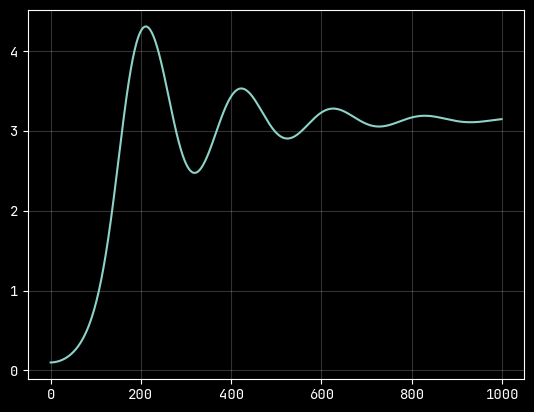

In [8]:
# test the integration
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from models_eq import SinglePendulum as SP, DoublePendulum as DP, CartSinglePendulum as CSP, CartDoublePendulum as CDP

def step(f, s, u, dt): # integrate one step with explicit euler
    n = s.shape[-1]
    s, ds = s[:n//2], s[n//2:] # split the state into position and velocity
    dds = f(*s, *ds, u)
    ds = ds + dds * dt
    s = s + ds * dt
    return np.concatenate([s, ds])

# single pendulum
dt = 0.01 # time step
nt = 1000 # number of time steps

# initial state
u = 0.0

ss = np.zeros((nt, 2))
ss[0] = [0.1, 0.0] # initial state

# integrate
for i in range(1, nt):
    ss[i] = step(SP.f, ss[i-1], u, dt)

# plot
plt.plot(ss[:,0])
plt.show()


